# Problem Statement: Sentiment Based Product Recommendation System

In [1]:
# importing the necessary libraries
import warnings
warnings.filterwarnings('ignore')
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics.pairwise import pairwise_distances
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

# 1. Developing the Sentiment Analyzer

In [2]:
# reading the dataset
df = pd.read_csv('sample30.csv')

In [3]:
# displaying top 5 rows of the dataset
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


## Exploratory Data Analysis (EDA)

In [4]:
# checking for null values in the dataset
df.isnull().sum(axis = 0)

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [5]:
# removing the instance (1 instance) with null value of label, user_sentiment
df = df[df['user_sentiment'].notna()]

In [6]:
# exploring the classes of the label, user_sentiment
df['user_sentiment'].value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

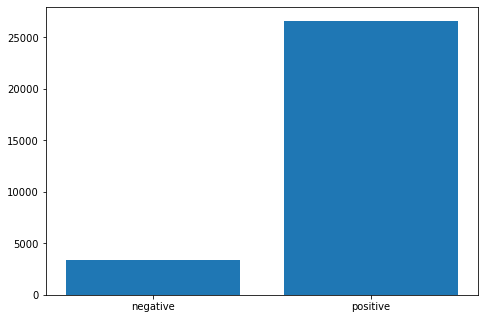

In [7]:
# Class Distribution of the label, user_sentiment
neg_label = Counter(df['user_sentiment'])['Negative']
pos_label = Counter(df['user_sentiment'])['Positive']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = ['negative', 'positive']
frequencies = [neg_label, pos_label]
ax.bar(classes, frequencies)
plt.show()

## The module, text_process for text pre-processing which includes text lower-casing, removal of punctuations & stopwords and finally verb-form lemmatization of each word in every review

In [8]:
def text_process(msg):
    # 1. all lower case
    # 2. remove punctuation and stopwords
    # 3. lemmatization
    msg = msg.lower()
    nopunct = [char for char in msg if char not in string.punctuation]
    nopunct = ''.join(nopunct)
    a = ''
    list_of_words = nopunct.split()
    for i in range(len(list_of_words)):
        if list_of_words[i] not in stopwords.words('english'):
            b = WordNetLemmatizer().lemmatize(list_of_words[i], pos="v")
            a = a + b + ' '
    a = a.rstrip()
    return a

In [9]:
df['reviews_text'] = df['reviews_text'].apply(text_process)

In [10]:
# labelling the positive user sentiments as 1 and negative ones as 0
df['user_sentiment'] = df['user_sentiment'].map({'Positive':1, 'Negative':0})

In [11]:
# splitting the features, X as the text reviews and y as the labels (here user-sentiments)
X = df['reviews_text']
y = df['user_sentiment']

In [12]:
# 80-20 splitting into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [13]:
# tf-idf vectorization of the Training Data and transforming the test data
vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(X_train.values.astype('U'))
tfidf_test = vectorizer.transform(X_test.values.astype('U'))

In [14]:
# getting the class label distribution in the training data
y_train.value_counts()

1    21285
0     2714
Name: user_sentiment, dtype: int64

## 1.1 Training the Logistic Regression Model for Text Classification

In [15]:
# instantiating the Logistic Regression Classifier with more class weight for label, 0 (minority class)
clf = LogisticRegression(class_weight = {0: 0.6, 1: 0.4}, random_state = 1234)
# performing 5-fold Grid Search Cross Validation for tuning the hyper-parameter, C
parameters = {'C':[0.01, 0.1, 1, 10, 100]}
folds = 5
grid_search = GridSearchCV(param_grid = parameters, 
                           estimator = clf, 
                           cv = folds,
                           verbose = 3,
                           return_train_score = True)

In [16]:
grid_search = grid_search.fit(tfidf_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .........................................C=0.01; total time=   0.0s
[CV 2/5] END .........................................C=0.01; total time=   0.0s
[CV 3/5] END .........................................C=0.01; total time=   0.0s
[CV 4/5] END .........................................C=0.01; total time=   0.0s
[CV 5/5] END .........................................C=0.01; total time=   0.0s
[CV 1/5] END ..........................................C=0.1; total time=   0.3s
[CV 2/5] END ..........................................C=0.1; total time=   0.1s
[CV 3/5] END ..........................................C=0.1; total time=   0.0s
[CV 4/5] END ..........................................C=0.1; total time=   0.1s
[CV 5/5] END ..........................................C=0.1; total time=   0.0s
[CV 1/5] END ............................................C=1; total time=   0.2s
[CV 2/5] END ....................................

In [17]:
# getting the best value of hyper-parameter, C
grid_search.best_params_

{'C': 10}

In [18]:
# re-training the Logistic Regression Model on the Training Set with the best value of hyper-parameter, C
lr_model = LogisticRegression(C = 10, class_weight = {0: 0.6, 1: 0.4}, random_state = 1234).fit(tfidf_train, y_train)

In [19]:
# getting the predicted probabilities and predictions for the Training Set
y_train_prob = lr_model.predict_proba(tfidf_train)
y_train_pred = lr_model.predict(tfidf_train)

In [20]:
# custom thresholding on the Training Set
y_train_df = pd.DataFrame({'label':y_train, 'predicted':y_train_pred, 'probability':y_train_prob[:,1]})
numbers = [float(x)/100 for x in range(100)]
for i in numbers:
    y_train_df[i] = y_train_df['probability'].map(lambda x: 1 if x >= i else 0)

In [21]:
# Calculation of accuracy, sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame(columns = ['prob','accuracy','sensi','speci'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

for i in numbers:
    cm1 = metrics.confusion_matrix(y_train_df['label'], y_train_df[i])
    total1 = sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [i, accuracy, sensi, speci]

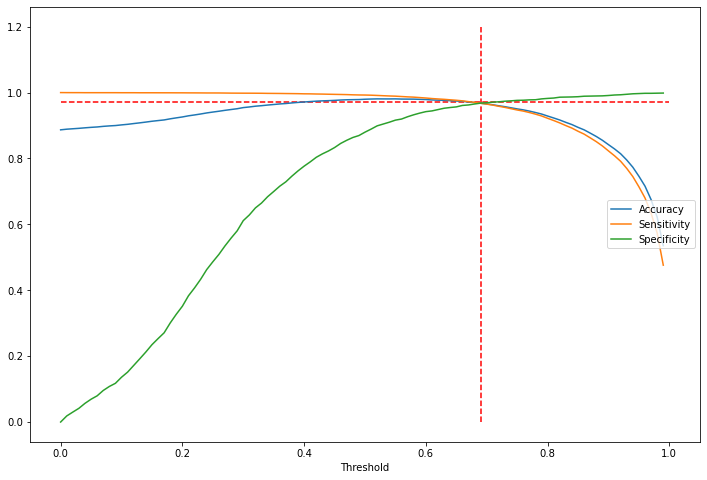

In [22]:
# plotting the Accuracy, Sensitivity and Specificity Curves at different thresholds
fig = plt.figure(figsize=[12,8])
plt.vlines(x=0.69, ymax=1.2, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.97, xmax=1, xmin=0, colors="r", linestyles="--")
plt.plot(cutoff_df['accuracy'])
plt.plot(cutoff_df['sensi'])
plt.plot(cutoff_df['speci'])
plt.legend(['Accuracy', 'Sensitivity', 'Specificity'], loc='center right')
plt.xlabel('Threshold')
plt.show()

### taking the threshold of 0.69 to be 0.75 as number of false positives needs to be minimized, hence Specificity needs to be increased

In [23]:
y_train_pred = [1 if predict_prob >= 0.75 else 0 for predict_prob in y_train_prob[:,1]]

In [24]:
# getting the predicted probabilities and predictions for the Test Set with 0.75 threshold
y_test_prob = lr_model.predict_proba(tfidf_test)
y_test_pred = [1 if predict_prob >= 0.75 else 0 for predict_prob in y_test_prob[:,1]]

In [25]:
# computing the accuracy and AUC score for the Training Set and Test Set
training_accuracy = metrics.accuracy_score(y_train, y_train_pred)

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob[:, 1])
roc_auc = metrics.auc(fpr, tpr)

training_auc = roc_auc


test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

test_auc = roc_auc

In [26]:
print("Training Accuracy: ", training_accuracy)
print("Test Accuracy: ", test_accuracy)
print("\n")
print("Training AUC: ", training_auc)
print("Test AUC: ", test_auc)

Training Accuracy:  0.9504562690112088
Test Accuracy:  0.9165


Training AUC:  0.992533153162791
Test AUC:  0.9595525363652271


### computing the Confusion Matrix, Precision, Recall and F1-Score for both Training Set and Test Set

In [27]:
confusion = metrics.confusion_matrix(y_train, y_train_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

print('Training Precision: ', precision)
print('Training Recall: ', recall)
print('Training F1-Score: ', f1)
print('Training Confusion Matrix: ')
print(confusion)
print('\n')

confusion = metrics.confusion_matrix(y_test, y_test_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

print('Testing Precision: ', precision)
print('Testing Recall: ', recall)
print('Testing F1-Score: ', f1)
print('Testing Confusion Matrix: ')
print(confusion)
print('\n')

Training Precision:  0.9968354430379747
Training Recall:  0.9471458773784355
Training F1-Score:  0.9713556096268279
Training Confusion Matrix: 
[[ 2650    64]
 [ 1125 20160]]


Testing Precision:  0.9819013524264121
Testing Recall:  0.9233214886852441
Testing F1-Score:  0.9517108433734941
Testing Confusion Matrix: 
[[ 562   91]
 [ 410 4937]]




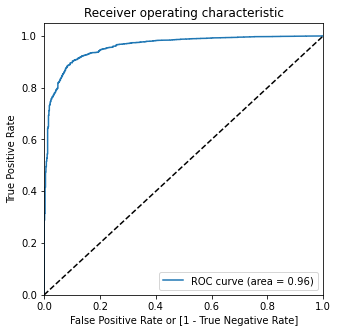

In [28]:
# displaying the ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob[:,1],
                                         drop_intermediate = False)
auc_score = metrics.roc_auc_score(y_test, y_test_prob[:,1])
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [29]:
# getting the class label distribution in the training data
y_train.value_counts()

1    21285
0     2714
Name: user_sentiment, dtype: int64

## 1.2 Training the Multinomial Naive Bayes Model for Text Classification

### Applying Synthetic Minority Over-sampling Technique (SMOTe) on Training Data

In [30]:
smote = SMOTE(random_state = 1234)
tfidf_train_smote, y_train_smote = smote.fit_resample(tfidf_train, y_train)
# getting the class label distribution in the training data after SMOTe
Counter(y_train_smote)

Counter({1: 21285, 0: 21285})

In [31]:
# training the Multinomial Naive Bayes Model on the SMOTe over-sampled Training Data
nb_clf = MultinomialNB().fit(tfidf_train_smote, y_train_smote)

In [32]:
# getting the predicted probability and predictions for the SMOTe over-sampled Training Data
y_train_prob = nb_clf.predict_proba(tfidf_train_smote)
y_train_pred = nb_clf.predict(tfidf_train_smote)

In [33]:
# custom thresholding on the Training Set
y_train_df = pd.DataFrame({'label':y_train_smote, 'predicted':y_train_pred, 'probability':y_train_prob[:,1]})
numbers = [float(x)/100 for x in range(100)]
for i in numbers:
    y_train_df[i] = y_train_df['probability'].map(lambda x: 1 if x >= i else 0)

In [34]:
# Calculation of accuracy, sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame(columns = ['prob','accuracy','sensi','speci'])
from sklearn import metrics

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

for i in numbers:
    cm1 = metrics.confusion_matrix(y_train_df['label'], y_train_df[i])
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[i,accuracy,sensi,speci]

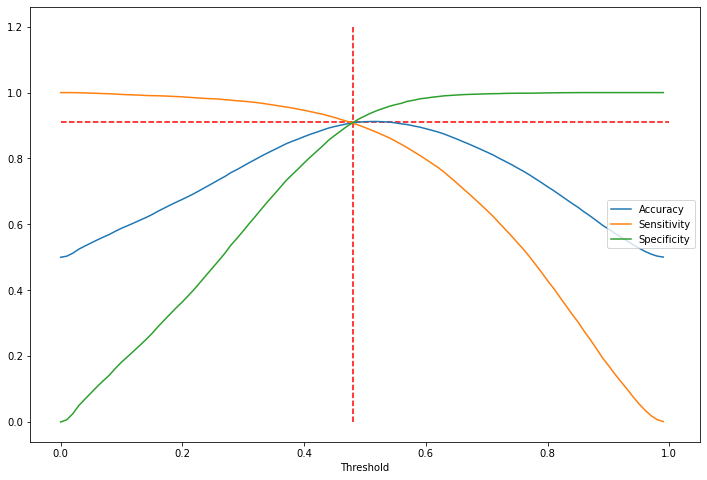

In [35]:
# plotting the Accuracy, Sensitivity and Specificity Curves at different thresholds
fig = plt.figure(figsize=[12,8])
plt.vlines(x=0.48, ymax=1.2, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.91, xmax=1, xmin=0, colors="r", linestyles="--")
plt.plot(cutoff_df['accuracy'])
plt.plot(cutoff_df['sensi'])
plt.plot(cutoff_df['speci'])
plt.legend(['Accuracy', 'Sensitivity', 'Specificity'], loc='center right')
plt.xlabel('Threshold')
plt.show()

### taking the threshold of 0.48 to be 0.55 as number of false positives needs to be minimized, hence Specificity needs to be increased

In [36]:
y_train_pred = [1 if predict_prob >= 0.55 else 0 for predict_prob in y_train_prob[:,1]]

In [37]:
# getting the predicted probabilities and predictions for the Test Set with 0.55 threshold
y_test_prob = nb_clf.predict_proba(tfidf_test)
y_test_pred = [1 if predict_prob >= 0.55 else 0 for predict_prob in y_test_prob[:,1]]

In [38]:
# computing the accuracy and AUC score for the Training Set and Test Set
training_accuracy = metrics.accuracy_score(y_train_smote, y_train_pred)

fpr, tpr, thresholds = metrics.roc_curve(y_train_smote, y_train_prob[:, 1])
roc_auc = metrics.auc(fpr, tpr)

training_auc = roc_auc


test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

test_auc = roc_auc

In [39]:
print("Training Accuracy: ", training_accuracy)
print("Test Accuracy: ", test_accuracy)
print("\n")
print("Training AUC: ", training_auc)
print("Test AUC: ", test_auc)

Training Accuracy:  0.9079633544749823
Test Accuracy:  0.8113333333333334


Training AUC:  0.9625894411829479
Test AUC:  0.866451712127795


### computing the Confusion Matrix, Precision, Recall and F1-Score for both Training Set and Test Set

In [40]:
confusion = metrics.confusion_matrix(y_train_smote, y_train_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

print('Training Precision: ', precision)
print('Training Recall: ', recall)
print('Training F1-Score: ', f1)
print('Training Confusion Matrix: ')
print(confusion)
print('\n')

confusion = metrics.confusion_matrix(y_test, y_test_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

print('Testing Precision: ', precision)
print('Testing Recall: ', recall)
print('Testing F1-Score: ', f1)
print('Testing Confusion Matrix: ')
print(confusion)
print('\n')

Training Precision:  0.9587405568175815
Training Recall:  0.852619215409913
Training F1-Score:  0.9025712438454269
Training Confusion Matrix: 
[[20504   781]
 [ 3137 18148]]


Testing Precision:  0.9624753127057275
Testing Recall:  0.8202730503085842
Testing F1-Score:  0.885702746365105
Testing Confusion Matrix: 
[[ 482  171]
 [ 961 4386]]




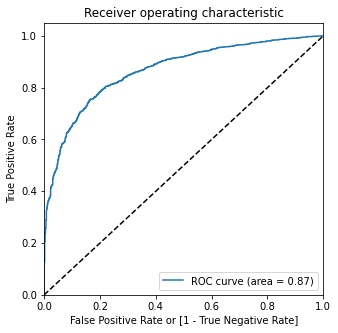

In [41]:
# displaying the ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob[:,1],
                                         drop_intermediate = False)
auc_score = metrics.roc_auc_score(y_test, y_test_prob[:,1])
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## 1.3 Training the XGBoost Model for Text Classification

In [42]:
# instantiating the XGBoost Classifier with eval_metric as logloss and considered is the SMOTe Over-sampled Training Data
clf = XGBClassifier(eval_metric = 'logloss', random_state = 1234)
# performing 5-fold Grid Search Cross Validation for tuning the hyper-parameters, learning rate and subsample
parameters = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}
folds = 5
grid_search = GridSearchCV(param_grid = parameters, 
                           estimator = clf, 
                           cv = folds,
                           verbose = 3,
                           return_train_score = True)

In [43]:
grid_search = grid_search.fit(tfidf_train_smote, y_train_smote)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...............learning_rate=0.2, subsample=0.3; total time=   7.9s
[CV 2/5] END ...............learning_rate=0.2, subsample=0.3; total time=   7.1s
[CV 3/5] END ...............learning_rate=0.2, subsample=0.3; total time=   6.6s
[CV 4/5] END ...............learning_rate=0.2, subsample=0.3; total time=   7.1s
[CV 5/5] END ...............learning_rate=0.2, subsample=0.3; total time=   6.3s
[CV 1/5] END ...............learning_rate=0.2, subsample=0.6; total time=  10.7s
[CV 2/5] END ...............learning_rate=0.2, subsample=0.6; total time=  10.0s
[CV 3/5] END ...............learning_rate=0.2, subsample=0.6; total time=   9.9s
[CV 4/5] END ...............learning_rate=0.2, subsample=0.6; total time=  10.3s
[CV 5/5] END ...............learning_rate=0.2, subsample=0.6; total time=   9.9s
[CV 1/5] END ...............learning_rate=0.2, subsample=0.9; total time=  13.1s
[CV 2/5] END ...............learning_rate=0.2, su

In [44]:
# getting the best values of hyper-parameters, learning rate and subsample
grid_search.best_params_

{'learning_rate': 0.6, 'subsample': 0.9}

In [45]:
# re-training the XGBoost Model on the SMOTe Over-sampled Training Set with the best values of hyper-parameters
xgb_model = XGBClassifier(eval_metric = 'logloss', 
                          learning_rate = 0.6, 
                          subsample = 0.9, 
                          random_state = 1234).fit(tfidf_train_smote, y_train_smote)

In [46]:
# getting the predicted probabilities and predictions for the Training Set
y_train_prob = xgb_model.predict_proba(tfidf_train_smote)
y_train_pred = xgb_model.predict(tfidf_train_smote)

In [47]:
# custom thresholding on the Training Set
y_train_df = pd.DataFrame({'label':y_train_smote, 'predicted':y_train_pred, 'probability':y_train_prob[:,1]})
numbers = [float(x)/100 for x in range(100)]
for i in numbers:
    y_train_df[i] = y_train_df['probability'].map(lambda x: 1 if x >= i else 0)

In [48]:
# Calculation of accuracy, sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame(columns = ['prob','accuracy','sensi','speci'])
from sklearn import metrics

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

for i in numbers:
    cm1 = metrics.confusion_matrix(y_train_df['label'], y_train_df[i])
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[i,accuracy,sensi,speci]

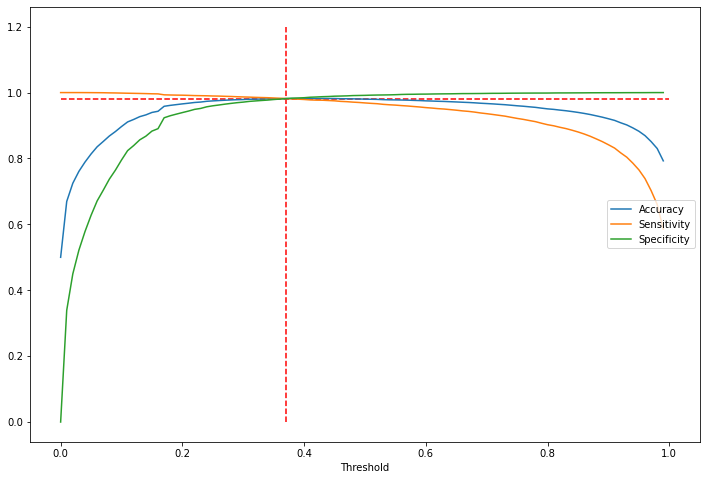

In [49]:
# plotting the Accuracy, Sensitivity and Specificity Curves at different thresholds
fig = plt.figure(figsize=[12,8])
plt.vlines(x=0.37, ymax=1.2, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.98, xmax=1, xmin=0, colors="r", linestyles="--")
plt.plot(cutoff_df['accuracy'])
plt.plot(cutoff_df['sensi'])
plt.plot(cutoff_df['speci'])
plt.legend(['Accuracy', 'Sensitivity', 'Specificity'], loc='center right')
plt.xlabel('Threshold')
plt.show()

### taking the threshold of 0.37 to be 0.45 as number of false positives needs to be minimized, hence Specificity needs to be increased

In [50]:
y_train_pred = [1 if predict_prob >= 0.45 else 0 for predict_prob in y_train_prob[:,1]]

In [51]:
# getting the predicted probabilities and predictions for the Test Set with 0.45 threshold
y_test_prob = xgb_model.predict_proba(tfidf_test)
y_test_pred = [1 if predict_prob >= 0.45 else 0 for predict_prob in y_test_prob[:,1]]

In [52]:
# computing the accuracy and AUC score for the Training Set and Test Set
training_accuracy = metrics.accuracy_score(y_train_smote, y_train_pred)

fpr, tpr, thresholds = metrics.roc_curve(y_train_smote, y_train_prob[:, 1])
roc_auc = metrics.auc(fpr, tpr)

training_auc = roc_auc


test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

test_auc = roc_auc

In [53]:
print("Training Accuracy: ", training_accuracy)
print("Test Accuracy: ", test_accuracy)
print("\n")
print("Training AUC: ", training_auc)
print("Test AUC: ", test_auc)

Training Accuracy:  0.982006107587503
Test Accuracy:  0.9338333333333333


Training AUC:  0.9980687459790005
Test AUC:  0.9527516252619508


### computing the Confusion Matrix, Precision, Recall and F1-Score for both Training Set and Test Set

In [54]:
confusion = metrics.confusion_matrix(y_train_smote, y_train_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

print('Training Precision: ', precision)
print('Training Recall: ', recall)
print('Training F1-Score: ', f1)
print('Training Confusion Matrix: ')
print(confusion)
print('\n')

confusion = metrics.confusion_matrix(y_test, y_test_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = (2*precision*recall)/(precision+recall)

print('Testing Precision: ', precision)
print('Testing Recall: ', recall)
print('Testing F1-Score: ', f1)
print('Testing Confusion Matrix: ')
print(confusion)
print('\n')

Training Precision:  0.9888968310698117
Training Recall:  0.974958891237961
Training F1-Score:  0.981878400757038
Training Confusion Matrix: 
[[21052   233]
 [  533 20752]]


Testing Precision:  0.9714285714285714
Testing Recall:  0.9538058724518421
Testing F1-Score:  0.9625365669529112
Testing Confusion Matrix: 
[[ 503  150]
 [ 247 5100]]




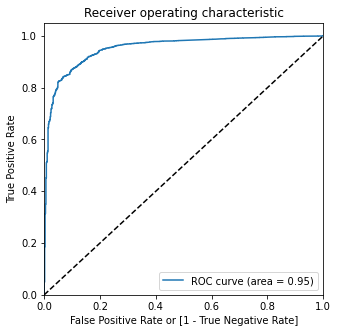

In [55]:
# displaying the ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob[:,1],
                                         drop_intermediate = False)
auc_score = metrics.roc_auc_score(y_test, y_test_prob[:,1])
plt.figure(figsize=(5, 5))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Clealy, Logistic Regression performed the best among the 3 models considered here (especially in terms of Precision and AUC Score). So, it is finalized as the Sentiment Analyzer

In [56]:
# saving the tf-idf vectorizer model object
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [57]:
# saving the logistic regression model object
joblib.dump(lr_model, 'lr_model.pkl')

['lr_model.pkl']

In [58]:
# saving the predicted sentiments by the model for the whole dataset (for speeding up Flask Application in Heroku Deployment)
tfidf_text = vectorizer.transform([review for review in df['reviews_text'].values.astype('U')])
df['predicted_user_sentiment'] = lr_model.predict(tfidf_text)

In [59]:
# saving the final dataframe containing predicted sentiments
df.to_csv('sample30_final.csv', index = False)

# 2. Developing the Recommendation System

In [60]:
# re-loading the whole dataset
df = pd.read_csv('sample30.csv')

In [61]:
# displaying the first 5 rows of the dataset
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [62]:
# considering the columns containing usernames (reviews_username), product names (name) and ratings (reviews_rating) 
ratings = df.loc[:, ['reviews_username', 'name', 'reviews_rating']]

In [63]:
# displaying top 5 rows of the ratings dataframe
ratings.head()

,reviews_username,name,reviews_rating
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
3,rebecca,K-Y Love Sensuality Pleasure Gel,1
4,walker557,K-Y Love Sensuality Pleasure Gel,1


In [64]:
# displaying the shape of the ratings dataset
ratings.shape

(30000, 3)

### To avoid repeated (user_id, product_id) pairs, they are grouped by and aggregated by the mean of the ratings

In [65]:
grouped_ratings = ratings.groupby(['reviews_username', 'name'])['reviews_rating'].mean()
ratings = grouped_ratings.reset_index()

In [66]:
# displaying the first 5 rows of the modified ratings dataframe
ratings.head()

,reviews_username,name,reviews_rating
0,00dog3,Chex Muddy Buddies Brownie Supreme Snack Mix,4.0
1,00sab00,Mike Dave Need Wedding Dates (dvd + Digital),1.0
2,00sab00,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,3.0
3,01impala,Godzilla 3d Includes Digital Copy Ultraviolet ...,3.0
4,02dakota,Godzilla 3d Includes Digital Copy Ultraviolet ...,5.0


In [67]:
# displaying the shape of the ratings dataset
ratings.shape

(27588, 3)

### The decrease in the number of rows from 30000 to 27588 indicates that there were indeed repeated (user_id, product_id) pairs

In [68]:
# 70-30 splitting into training and test data
train, test = train_test_split(ratings, test_size=0.30, random_state=1234)

## Building the User-User Recommendation System

In [69]:
# pivoting the train ratings' dataset into matrix format in which columns are products and the rows are usernames.
df_pivot = train.pivot(index='reviews_username',
                       columns='name',
                       values='reviews_rating')
df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# copying the train dataset into dummy_train
dummy_train = train.copy()

In [71]:
# the products not rated by user is marked as 1 for prediction and those already rated are marked 0
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [72]:
# Convert the dummy train dataset into matrix format in which columns are products and the rows are usernames
dummy_train = dummy_train.pivot(index='reviews_username',
                                columns='name',
                                values='reviews_rating').fillna(1)
dummy_train.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [73]:
# subtracting the ratings from their respective mean for each user
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [74]:
# calculating user correlation using adjusted cosine
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
# replacing the NaN correlation values by 0
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [75]:
# replacing the negative correlation values by 0
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
# predicting user ratings
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 5.72687113, 0.        , ..., 5.08496515, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [77]:
# getting the final user predicted ratings
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
00sab00,0.0,5.726871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.414214,...,0.816497,0.0,0.0,0.0,0.0,0.0,0.0,5.084965,0.0,0.0
01impala,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
02deuce,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [78]:
# taking the username as input
user_input = input("Enter your username: ")

Enter your username: rebecca


In [79]:
# recommending top 5 products to the user 
user_final_rating.loc[user_input].sort_values(ascending=False)[0:5]

name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd    17.746552
Mike Dave Need Wedding Dates (dvd + Digital)                       11.882965
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                6.788884
Clorox Disinfecting Bathroom Cleaner                                6.118116
Coty Airspun Face Powder, Translucent Extra Coverage                5.235344
Name: rebecca, dtype: float64

### Evaluation of User-User Recommender Model

In [80]:
# finding out the users common to test and train dataset
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1066, 3)

In [81]:
common.head()

,reviews_username,name,reviews_rating
20430,peanut,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,4.000000
18519,mouse,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,5.000000
18553,moviegoer,Mike Dave Need Wedding Dates (dvd + Digital),3.000000
3742,byamazon customer,"Lundberg Wehani Rice, 25lb",4.578947
24377,steve,Red (special Edition) (dvdvideo),5.000000


In [82]:
# converting into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [83]:
common_user_based_matrix.shape

(871, 122)

### converting the user_correlation matrix into dataframe and getting the correlations for users common to training and test set

In [84]:
user_correlation_df = pd.DataFrame(user_correlation)

In [85]:
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17839,17840,17841,17842,17843,17844,17845,17846,17847,17848
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
common.head(1)

,reviews_username,name,reviews_rating
20430,peanut,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,4.0


In [87]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()

user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [88]:
user_correlation_df_1.shape

(871, 17849)

In [89]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [90]:
user_correlation_df_3 = user_correlation_df_2.T

In [91]:
user_correlation_df_3.head()

,1234,1witch,abbi,abby,acjuarez08,actionaction,adam,adrienne,ah78,ajay,...,wildman,winniepoo2,wizard,wolfie,wonderwoman,woody,woottos,woowoo,xstr8edgex,yeyo
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acjuarez08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [93]:
# preparing the dummy test dataset in a way such that for rated products, the rating is 1, else 0

dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [94]:
dummy_test.head()

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acjuarez08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
# convering the common dataframe into user-product matrix
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [96]:
common_user_predicted_ratings.head(2)

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
# copying the common user predicted ratings
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

# copying the common user predicted ratings
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [98]:
# convering the common dataframe into user-product matrix
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [99]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [100]:
# calculating RMSE score
rmse = ((((common_ - y)**2).sum(skipna = True)).sum(skipna = True)/total_non_nan)**0.5
print('Root Mean Square Error of the User-based Recommender: ', rmse)

Root Mean Square Error of the User-based Recommender:  2.5842040534180777


## Building the Item-Item Recommendation System

In [101]:
# Pivoting the train ratings' dataset into matrix format in which columns are usernames and the rows are products.
df_pivot = train.pivot(index='reviews_username',
                       columns='name',
                       values='reviews_rating').T

df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02deuce,0325home,06stidriver,09mommy11,1.11E+24,1085,10ten,...,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
# subtracting the ratings from their respective mean for each product
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [103]:
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02deuce,0325home,06stidriver,09mommy11,1.11E+24,1085,10ten,...,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
# calculating item correlation using adjusted cosine
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [105]:
# replacing the negative correlation values by 0
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [106]:
# predicting item ratings
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01144148, 0.00435427,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0040878 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0019102 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01063105, 0.00725712,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00152816, 0.        ,
        0.        ]])

In [107]:
# getting the final item predicted ratings 
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000666,...,0.046752,0.0,0.0,0.0,0.0,0.0,0.0,0.011441,0.004354,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000072,...,0.011394,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.004088,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000096,...,0.015192,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.005450,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001910,0.000000,0.0


In [108]:
# taking the username as input
user_input = input("Enter your username: ")

Enter your username: rebecca


In [109]:
# recommending top 5 products to the user 
item_final_rating.loc[user_input].sort_values(ascending=False)[0:5]

name
Clorox Disinfecting Bathroom Cleaner                            0.845140
Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home    0.421607
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)           0.230212
Stacy's Simply Naked Bagel Chips                                0.221337
Just For Men Touch Of Gray Gray Hair Treatment, Black T-55      0.215650
Name: rebecca, dtype: float64

### Evaluation of Item-Item Recommender Model

In [110]:
# finding out the products common to test and train dataset
common =  test[test.name.isin(train.name)]
common.shape

(8255, 3)

In [111]:
common.head()

,reviews_username,name,reviews_rating
20430,peanut,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,4.0
27262,wyoshopgril,"Storkcraft Tuscany Glider and Ottoman, Beige C...",5.0
18519,mouse,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,5.0
22266,ryan21121,Red (special Edition) (dvdvideo),5.0
6927,deb in hr,"Pendaflex174 Divide It Up File Folder, Multi S...",5.0


In [112]:
# converting into the product-user matrix.
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

### converting the item_correlation matrix into dataframe and getting the correlations for items common to training and test set

In [113]:
item_correlation_df = pd.DataFrame(item_correlation)

In [114]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
list_name = common.name.tolist()

In [116]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [117]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [118]:
item_correlation_df_3.head()

,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
100:Complete First Season (blu-Ray),1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Africa's Best No-Lye Dual Conditioning Relaxer System Super,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 5.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00681299, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [120]:
# preparing the dummy test dataset in a way such that for rated products, the marking is 1, else 0

dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [121]:
# convering the common dataframe into product-user matrix
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [122]:
# copying the common item predicted ratings
X  = common_item_predicted_ratings.copy() 
X = X[X>0]
# scaling the ratings between 1 and 5
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [123]:
# finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [124]:
# calculating RMSE score
rmse = ((((common_ - y)**2).sum(skipna = True)).sum(skipna = True)/total_non_nan)**0.5
print('Root Mean Square Error of the User-based Recommender: ', rmse)

Root Mean Square Error of the User-based Recommender:  3.5678352577854886


## User-based Recommendation System yielded comparitively less RMSE Score and will recommend a variety of products to the users unlike Item-based. Hence, is selected as the Best Recommender Model

In [125]:
user_final_rating.to_csv('user_final_rating.csv')

In [126]:
# taking the username as input.
user_input = input("Enter your username: ")
if user_input not in list(user_final_rating.index):
    print('Sorry !!! The username is not registered !!!')

Enter your username: rebecca


In [127]:
# recommending top 20 products to the user
recommended_user_based_products = pd.DataFrame(user_final_rating.loc[user_input].sort_values(ascending=False))[0:20]

In [128]:
recommended_user_based_products

,rebecca
name,
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,17.746552
Mike Dave Need Wedding Dates (dvd + Digital),11.882965
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),6.788884
Clorox Disinfecting Bathroom Cleaner,6.118116
"Coty Airspun Face Powder, Translucent Extra Coverage",5.235344
The Resident Evil Collection 5 Discs (blu-Ray),4.253583
Chester's Cheese Flavored Puffcorn Snacks,3.947963
"Burt's Bees Lip Shimmer, Raisin",3.874682
The Honest Company Laundry Detergent,3.592439


# 3. Fine-tuning the Recommender Model using the Sentiment Analyzer to select top 5 products with mostly positive reviews

In [129]:
df_predicted_user_sentiments = pd.read_csv('sample30_final.csv') # reading the dataframe having predicted ratings by sentiment analyzer

positive_products = []
for product in recommended_user_based_products.index:
    predicted_sentiments = np.array(df_predicted_user_sentiments.loc[df_predicted_user_sentiments.name == product, 'predicted_user_sentiment'])
    final_sentiment = Counter(predicted_sentiments).most_common()[0][0]
    if final_sentiment == 1:
        positive_products.append(product)
    if len(positive_products) == 5:
        break

In [130]:
# getting the 5 final recommended product details like brand, categories and manufacturer along with the name
recommended_user_based_product_details = {}
recommended_user_based_product_details['name'] = []
recommended_user_based_product_details['brand'] = []
recommended_user_based_product_details['categories'] = []
recommended_user_based_product_details['manufacturer'] = []

for products in positive_products:
    recommended_user_based_product_details['brand'].append(df.loc[df.name == products, 'brand'].iloc[0])
    recommended_user_based_product_details['categories'].append(df.loc[df.name == products, 'categories'].iloc[0])
    recommended_user_based_product_details['manufacturer'].append(df.loc[df.name == products, 'manufacturer'].iloc[0])
    recommended_user_based_product_details['name'].append(products)    

In [131]:
pd.DataFrame(recommended_user_based_product_details)

,name,brand,categories,manufacturer
0,Godzilla 3d Includes Digital Copy Ultraviolet ...,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test
1,Mike Dave Need Wedding Dates (dvd + Digital),FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Twentieth Century Fox
2,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,Universal Home Video,"Movies, Music & Books,Movies,Comedy,Movies & T...",Universal
3,Clorox Disinfecting Bathroom Cleaner,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7
4,"Coty Airspun Face Powder, Translucent Extra Co...",Coty,"Personal Care,Makeup,Concealer & Foundation,Fo...",Coty brands


#### GitHub Repository Link: https://github.com/navoneel1092283/Sentiment_Based_Product_Recommender
#### Flask Web Application Link deployed in Heroku: https://sbpr.herokuapp.com/